In [ ]:

# Import common libraries
import os
import contextlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ttest_rel, shapiro, kstest, wilcoxon

from itertools import compress


# Import MNE-Python processing
import mne
import mne_nirs
from mne.preprocessing.nirs import optical_density, beer_lambert_law

from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair)
from mne import Epochs, events_from_annotations
from mne.decoding import (Scaler,
                          cross_val_multiscore,
                          Vectorizer)
from epochs_processing import *
%matplotlib auto

In [33]:
# 1) карты
# 2) кривые (типа вп) из целевых областей. (усреднить датчики вокруг с3) 
# 3) кривые (типа вп из ипсилатерального полушария (усреднить датчики вокруг С4)

In [34]:
raw = mne.io.read_raw_nirx("/home/avaldamon/Desktop/fNIRS_TI_MI/MK_FNIRS/MK_TI/", preload=True)
raw_od = optical_density(raw)

raw_od = temporal_derivative_distribution_repair(raw_od)

# sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
# raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))

raw_haemo_ = beer_lambert_law(raw_od, ppf=0.1)
# unfiltered = raw_haemo_.copy()
raw_haemo = raw_haemo_.filter(0.05, 0.2, h_trans_bandwidth=0.2,
                             l_trans_bandwidth=0.02)
raw_haemo.resample(5)
chnames = raw_haemo.ch_names

Loading /home/avaldamon/Desktop/fNIRS_TI_MI/MK_FNIRS/MK_TI/
Reading 0 ... 6571  =      0.000 ...   645.956 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.20 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.30 Hz)
- Filter length: 1679 samples (165.052 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 222 out of 222 | elapsed:    0.1s finished


In [35]:
optodes_to_eeg_montage = [
    'FC3', 'FC4', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'FCC2h',
    'FCC4h', 'FCC6h', 'FTT8h', 'C5', 'C1', 'C2', 'C6', 'TTP7h',
    'CCP5h', 'CCP3h', 'CCP3h', 'CCP1h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h'
]
optodes_of_interest = [
    'D10', 'D11', 'D12', 'S09', 'D13', 'S10', 'S11', 'D14',
'S12', 'D15', 'S13', 'D16', 'D17', 'S14', 'S15', 'D18',
'S16', 'D19', 'D20', 'S17', 'D21', 'S18'
]
optodes_to_channels = dict(zip(optodes_to_eeg_montage, optodes_of_interest))

C3 = ['FC3', 'FCC5h', 'FCC3h', 'FCC1h', 'C5', 'C1', 'CCP5h', 'CCP3h']
C4 = ['FC4', 'FCC4h', 'FCC6h', 'FCC2h', 'C2', 'C6', 'CCP4h', 'CCP6h']

C3_channels = [optodes_to_channels[i] for i in C3]
C4_channels = [optodes_to_channels[i] for i in C4]

In [36]:
# raw_haemo.plot()

# hbos_of_interest = [x for x in hbo_chans if any(y in x for y in optodes_of_interest)]
# hbrs_of_interest = [x for x in hbr_chans if any(y in x for y in optodes_of_interest)]
def chans_of_interest(optodes_of_interest):
    chans_hbo = [x for x in chnames if any(y in x for y in optodes_of_interest) if 'hbo' in x]
    chans_hbr = [x for x in chnames if any(y in x for y in optodes_of_interest) if 'hbr' in x]

    return chans_hbo, chans_hbr

chans_of_interest_hbo, chans_of_interest_hbr = chans_of_interest(C3_channels)

In [37]:
events, ids = mne.events_from_annotations(raw_haemo)
ids["Rest"] = 2
ids["Sensorimotor"] = 1
try:
    ids.pop("2.0")
    ids.pop("1.0")
except:
    ids.pop("2")
    ids.pop("1")

# epochs =  mne.Epochs(raw_haemo, events, ids, tmin=0, tmax=13, baseline=(0,0), preload=True, proj=True)

reject_criteria = dict(hbo=120-6)
tmin, tmax = -3, 15

raw_haemo.pick_channels(chans_of_interest_hbo+chans_of_interest_hbr)


epochs = mne.Epochs(raw_haemo, events, event_id=ids,
                    tmin=tmin, tmax=tmax,
                    reject=None, 
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=None, verbose=False)
epochs.plot_drop_log()

# epochs = mne.Epochs(raw_haemo, events, event_id=ids,
#                     tmin=tmin, tmax=tmax,
#                     reject=None, 
#                     proj=True, baseline=(None, 0), preload=True,
#                     detrend=None, verbose=False)


# epochs = epochs.crop(3, 11)
rest_epochs = epochs["Rest"]
rest_epochs = rest_epochs.crop(4, 10)
smr_epochs = epochs["Sensorimotor"]
smr_epochs = smr_epochs.crop(4, 10)

Used Annotations descriptions: ['1.0', '2.0']


In [38]:
info = smr_epochs.info
chans = mne.io.pick.channel_indices_by_type(info)
info_hbo = mne.pick_info(info,chans['hbo'])


info_hbr = mne.pick_info(info,chans['hbr'])

hbo_chnames = info_hbo.ch_names
hbr_chanames = info_hbr.ch_names

smr_epochs_data = smr_epochs.get_data()
rest_epochs_data = rest_epochs.get_data()

In [39]:
epochs['Sensorimotor'].plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))


Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [40]:
epochs['Rest'].plot_image(combine='mean', vmin=-30, vmax=30,
                             ts_args=dict(ylim=dict(hbo=[-15, 15],
                                                    hbr=[-15, 15])))


Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
combining channels using "mean"


[<Figure size 640x480 with 3 Axes>, <Figure size 640x480 with 3 Axes>]

In [41]:
evoked_dict = {'Sensorimotor/HbO': epochs['Sensorimotor'].average(picks='hbo'),
               'Sensorimotor/HbR': epochs['Sensorimotor'].average(picks='hbr'),
               'Rest/HbO': epochs['Rest'].average(picks='hbo'),
               'Rest/HbR': epochs['Rest'].average(picks='hbr')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377', HbR='b')
styles_dict = dict(Rest=dict(linestyle='dashed'))

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict, styles=styles_dict)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 1 Axes>]

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
clims = dict(hbo=[-20, 20], hbr=[-20, 20])
epochs['Rest'].average().plot_image(axes=axes[:, 0], clim=clims)
epochs['Sensorimotor'].average().plot_image(axes=axes[:, 1], clim=clims)
for column, condition in enumerate(['Rest', 'Sensorimotor']):
    for ax in axes[:, column]:
        ax.set_title('{}: {}'.format(condition, ax.get_title()))

No projector specified for this dataset. Please consider the method self.add_proj.


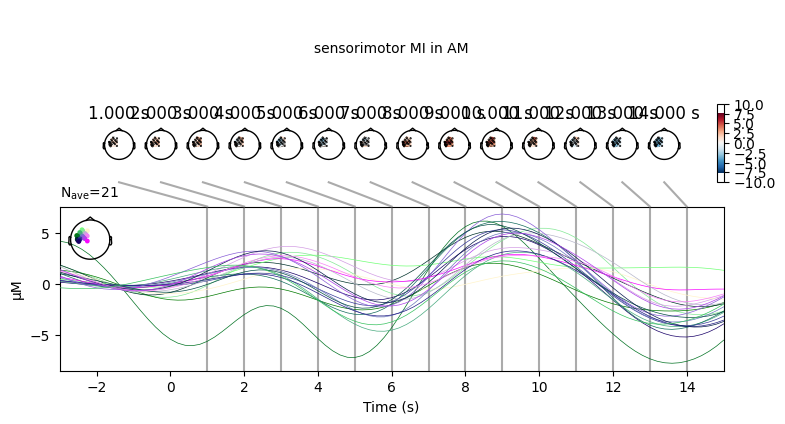

In [43]:
times = np.arange(1, 15., 1)
topomap_args = dict(extrapolate='local')
epochs['Sensorimotor'].average(picks='hbo').plot_joint(
    times=times, topomap_args=topomap_args, title='sensorimotor MI in AM')

No projector specified for this dataset. Please consider the method self.add_proj.


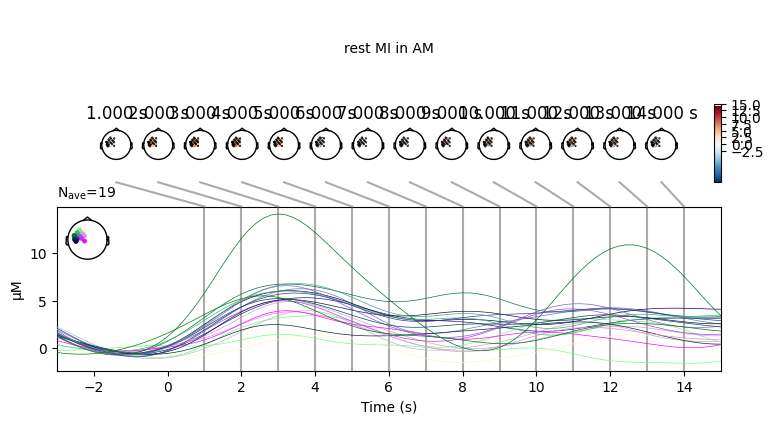

In [44]:
times = np.arange(1, 15., 1)
topomap_args = dict(extrapolate='local')
epochs['Rest'].average(picks='hbo').plot_joint(
    times=times, topomap_args=topomap_args, title='rest MI in AM')

In [187]:
median_smr = np.mean(smr_epochs_data, axis=2)
median_smr = np.mean(median_smr, axis=0)

median_rest = np.mean(rest_epochs_data, axis=2)
median_rest = np.mean(median_rest, axis=0)
length_hbo = len(raw_haemo.copy().pick_types(fnirs='hbo').ch_names)
length_hbr = len(raw_haemo.copy().pick_types(fnirs='hbr').ch_names)


In [190]:
plotting_total(median_smr[:len(hbo_chnames)], median_rest[:len(hbo_chnames)], "Mean HbO in SMR", "Mean HbO in rest", hbo_chnames)

In [151]:
median_smr_hbo, median_smr_hbr = median_smr[:, :length_hbo], median_smr[:, length_hbo:]
median_rest_hbo, median_rest_hbr = median_rest[:, :length_hbo], median_rest[:, length_hbo:]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [137]:
median_smr_hbo.shape

(17, 100)

In [248]:
for idx, data in enumerate(median_rest_hbo):
    plotting_total(data, title=str(idx))

/tmp/ipykernel_5219/591517977.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))


In [246]:
def plotting_total(data_smr, title):
    vlim=(-5*10**-6, 5*10**-6)


    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 6))

    im1, cn1 = mne.viz.plot_topomap(data=data_smr, pos=info_hbo, vlim=vlim,
                                    image_interp="cubic", extrapolate="local", axes=ax1)


    title_hbo = f"{title}"
    ax1.set_title(title_hbo, size=16)



    # Create a colorbar using a separate axis
#     cax = fig.add_axes([0.5, 0.2, 0.025, 0.6])  # Adjust the position of the colorbar as needed
#     cbar = plt.colorbar(im1, cax=cax)
#     cbar.set_label('Concentration')
#     fig.subplots_adjust(top=0.985,
#                         bottom=0.015,
#                         left=0.008,
#                         right=0.992,
#                         hspace=0.2,
#                         wspace=0.024)  # Adjust the values as needed

    plt.show()

In [189]:
def plotting_hbo_vs_hbr(median_smr, condition):
    vlim=(-5*10**-4, 5*10**-4)


    fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(12, 6))

    im1, cn1 = mne.viz.plot_topomap(data=median_smr[0:126], pos=info_hbo, vlim=vlim,
                                    image_interp="cubic", extrapolate="local", axes=ax1)

    im2, cn2 = mne.viz.plot_topomap(data=median_smr[126:], pos=info_hbo, vlim=vlim,
                                    image_interp="cubic", extrapolate="local", axes=ax2)

    title_hbo = f"Mean HbO in {condition}"
    ax1.set_title(title_hbo, size=16)

    title_hbr = f"Mean HbR in {condition}"
    ax2.set_title(title_hbr, size=16)

    # Remove the middle plot
    fig.delaxes(ax3)

    # Create a colorbar using a separate axis
    cax = fig.add_axes([0.5, 0.2, 0.025, 0.6])  # Adjust the position of the colorbar as needed
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label('Concentration')
    fig.subplots_adjust(left=0.18, right=0.8, bottom=0.2, top=0.9)  # Adjust the values as needed

    plt.show()
    
def plotting_total(data_smr, data_rest, condition_1, condition_2, names):
    vlim=(-10*10**-6, 10*10**-6)


    fig, (ax1, ax3, ax2) = plt.subplots(1, 3, figsize=(12, 6))

    im1, cn1 = mne.viz.plot_topomap(data=data_smr, pos=info_hbo, vlim=vlim,
                                    image_interp="cubic", extrapolate="local", axes=ax1)

    im2, cn2 = mne.viz.plot_topomap(data=data_rest, pos=info_hbo, vlim=vlim,
                                    image_interp="cubic", extrapolate="local", axes=ax2
                                   )

    title_hbo = f"{condition_1}"
    ax1.set_title(title_hbo, size=16)

    title_hbr = f"{condition_2}"
    ax2.set_title(title_hbr, size=16)

    # Remove the middle plot
    fig.delaxes(ax3)

    # Create a colorbar using a separate axis
    cax = fig.add_axes([0.5, 0.2, 0.025, 0.6])  # Adjust the position of the colorbar as needed
    cbar = plt.colorbar(im1, cax=cax)
    cbar.set_label('Concentration')
    fig.subplots_adjust(top=0.985,
                        bottom=0.015,
                        left=0.008,
                        right=0.992,
                        hspace=0.2,
                        wspace=0.024)  # Adjust the values as needed

    plt.show()



In [139]:
total_smr = median_smr[0:105] + median_smr[105:]
total_rest = median_rest[0:105] + median_rest[105:]

ValueError: operands could not be broadcast together with shapes (17,210) (0,210) 

In [18]:
im, cn = mne.viz.plot_topomap(data=median_rest[0:126], pos=info_hbo, outlines='skirt', 
                     image_interp="cubic", extrapolate="local", names=True )
plt.colorbar(im)

im, cn = mne.viz.plot_topomap(data=median_rest[126:], pos=info_hbo, outlines='skirt', 
                     image_interp="", extrapolate="local", names=True)
plt.colorbar(im)

/tmp/ipykernel_4015/2346050458.py:1: FutureWarning: Passing ``outlines='skirt'`` is deprecated; it no longer has any effect different from 'head' and will raise an error starting in version 1.3.
  im, cn = mne.viz.plot_topomap(data=median_rest[0:126], pos=info_hbo, outlines='skirt',


TypeError: object of type 'bool' has no len()

In [85]:
median_rest[0:126] + median_rest[126:]

array([ 5.51648796e-09,  1.56597483e-08,  1.26832964e-08, -6.55118538e-09,
        6.00702878e-08,  3.31714865e-08,  2.90295770e-08,  1.04295254e-08,
        3.45068998e-08, -1.55305745e-08, -8.39379450e-08, -4.38244612e-08,
        4.67236147e-08, -3.10069648e-08, -1.12901498e-07,  6.53427368e-08,
        5.96347938e-08,  2.84693552e-08,  3.18280753e-08,  1.53568425e-08,
       -2.62543796e-08, -6.05840334e-08,  1.74491204e-07,  3.06110631e-08,
        9.91390022e-08, -3.98407871e-08, -7.05087318e-08, -1.51460848e-07,
       -6.65518804e-08, -1.45475854e-07, -6.67168710e-08,  1.06610269e-09,
       -1.40642958e-07, -8.11977424e-08, -2.02149119e-07, -5.63335616e-08,
       -5.01678764e-08, -1.59067404e-07, -1.85476458e-07,  7.46347574e-08,
       -2.05615772e-08, -6.43716796e-08, -2.73145028e-08, -5.63135808e-08,
       -4.16134101e-08, -5.50586606e-09, -3.74530862e-08, -5.34134805e-08,
       -8.93884538e-08, -2.19047153e-08, -2.58446533e-07, -2.73931443e-07,
       -5.64823291e-08, -